# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

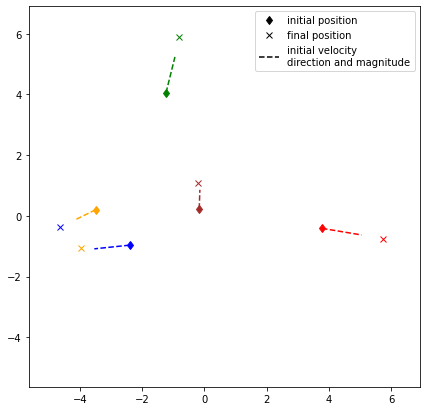

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [10]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model 1

The GraphNN-like model that makes predictions based on the embedding of the set. For each timestamp we train a separate model in this section. 

## Model Implementation

In [54]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModel(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 16, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32, output_size: int = 2, device: torch.device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        
        #### Getting Graph Embedding
        
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = gamma1_out

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.LeakyReLU())
        self.output_size = gamma2_out
        self.device = device
        self.prediction_size = output_size
        self.final_layer = nn.Sequential(nn.Linear(gamma2_out*set_size, output_size*set_size))

    
    def forward_iteration1(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration1(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate 
            # x of shape (batch_size, 1, num_features+fau_output)
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,i] = self.gamma_iteration1(x).view(particle_set.shape[0], -1)
        # for convenicence, swap axes when return
        return embeddings.swapaxes(1,2)

    def forward_iteration2(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[2], self.output_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration2(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate the neighborhood and 
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embeddings[:,i] = self.gamma_iteration2(x).view(particle_set.shape[0], -1)
        return embeddings

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        inner_emedding = self.forward_iteration1(particle_set = particle_set, distances = distances).to(self.device)
        embedding = self.forward_iteration2(particle_set = inner_emedding, distances = distances)
        
        prediction = self.final_layer(embedding.view(embedding.shape[0], -1))

        return prediction.view(embedding.shape[0], self.prediction_size, -1) # (particle_set.shape[0], 5, 2)

## Model Training

In [87]:
from tqdm import tqdm

class ParticleDistanceLoss(nn.Module):
    """
      The loss to calculate mean distance between predicted location of particle of each set.
      By defaul, Euclidean distance is set
    """

    def __init__(self, norm: float = 2):
        super(ParticleDistanceLoss, self).__init__()
        self.norm = norm

    def forward(self, input_set, target_set):
        """
            (batch_size, coordinates, set_size)
        """
        return (input_set - target_set).norm(p = self.norm, dim = 1).mean(axis = 1).mean()
        
        

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self, target_time):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                A, B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(A)  # one forward pass
                loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                A,B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(A)  # one forward pass
                    loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self, target_time):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                loss.append(self.criterion(out, B[:,time_to_ind[target_time]]))
        print(f'Error: {np.mean(loss):.4f} for target time {target_time}',end=' ')

## Experiments

### Training with max pooling

In [75]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer(target_time=0.5)
TrainingProcedure.evaluate(target_time=0.5)

  5%|▌         | 1/20 [00:02<00:38,  2.05s/it]

EPOCH: 01/20 LOSS: 0.5841 VAL-LOSS: 0.2566


 10%|█         | 2/20 [00:04<00:36,  2.04s/it]

EPOCH: 02/20 LOSS: 0.2414 VAL-LOSS: 0.2716


 15%|█▌        | 3/20 [00:06<00:34,  2.06s/it]

EPOCH: 03/20 LOSS: 0.2219 VAL-LOSS: 0.1926


 20%|██        | 4/20 [00:08<00:33,  2.07s/it]

EPOCH: 04/20 LOSS: 0.1945 VAL-LOSS: 0.1860


 25%|██▌       | 5/20 [00:10<00:30,  2.06s/it]

EPOCH: 05/20 LOSS: 0.1828 VAL-LOSS: 0.2198


 30%|███       | 6/20 [00:12<00:29,  2.07s/it]

EPOCH: 06/20 LOSS: 0.1814 VAL-LOSS: 0.1693


 35%|███▌      | 7/20 [00:14<00:27,  2.09s/it]

EPOCH: 07/20 LOSS: 0.1715 VAL-LOSS: 0.1742


 40%|████      | 8/20 [00:16<00:25,  2.08s/it]

EPOCH: 08/20 LOSS: 0.1744 VAL-LOSS: 0.1689


 45%|████▌     | 9/20 [00:18<00:22,  2.09s/it]

EPOCH: 09/20 LOSS: 0.1655 VAL-LOSS: 0.1621


 50%|█████     | 10/20 [00:21<00:22,  2.21s/it]

EPOCH: 10/20 LOSS: 0.1647 VAL-LOSS: 0.1669


 55%|█████▌    | 11/20 [00:23<00:19,  2.17s/it]

EPOCH: 11/20 LOSS: 0.1628 VAL-LOSS: 0.1600


 60%|██████    | 12/20 [00:25<00:17,  2.14s/it]

EPOCH: 12/20 LOSS: 0.1597 VAL-LOSS: 0.1628


 65%|██████▌   | 13/20 [00:27<00:14,  2.12s/it]

EPOCH: 13/20 LOSS: 0.1598 VAL-LOSS: 0.1663


 70%|███████   | 14/20 [00:29<00:12,  2.14s/it]

EPOCH: 14/20 LOSS: 0.1596 VAL-LOSS: 0.1679


 75%|███████▌  | 15/20 [00:31<00:10,  2.16s/it]

EPOCH: 15/20 LOSS: 0.1568 VAL-LOSS: 0.1695


 80%|████████  | 16/20 [00:34<00:09,  2.45s/it]

EPOCH: 16/20 LOSS: 0.1563 VAL-LOSS: 0.1651


 85%|████████▌ | 17/20 [00:36<00:06,  2.32s/it]

EPOCH: 17/20 LOSS: 0.1532 VAL-LOSS: 0.1567


 90%|█████████ | 18/20 [00:39<00:04,  2.31s/it]

EPOCH: 18/20 LOSS: 0.1530 VAL-LOSS: 0.1496


 95%|█████████▌| 19/20 [00:42<00:02,  2.61s/it]

EPOCH: 19/20 LOSS: 0.1510 VAL-LOSS: 0.1672


100%|██████████| 20/20 [00:44<00:00,  2.24s/it]

EPOCH: 20/20 LOSS: 0.1528 VAL-LOSS: 0.1529


Error: 0.1558 

In [76]:
model = ParticleModel(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer(target_time=1)
TrainingProcedure.evaluate(target_time=1)

  5%|▌         | 1/20 [00:02<00:40,  2.13s/it]

EPOCH: 01/20 LOSS: 0.7574 VAL-LOSS: 0.4170


 10%|█         | 2/20 [00:04<00:37,  2.11s/it]

EPOCH: 02/20 LOSS: 0.4039 VAL-LOSS: 0.4254


 15%|█▌        | 3/20 [00:06<00:35,  2.10s/it]

EPOCH: 03/20 LOSS: 0.3630 VAL-LOSS: 0.3407


 20%|██        | 4/20 [00:08<00:33,  2.12s/it]

EPOCH: 04/20 LOSS: 0.3400 VAL-LOSS: 0.3230


 25%|██▌       | 5/20 [00:10<00:31,  2.12s/it]

EPOCH: 05/20 LOSS: 0.3281 VAL-LOSS: 0.3271


 30%|███       | 6/20 [00:12<00:29,  2.11s/it]

EPOCH: 06/20 LOSS: 0.3213 VAL-LOSS: 0.3151


 35%|███▌      | 7/20 [00:14<00:27,  2.11s/it]

EPOCH: 07/20 LOSS: 0.3138 VAL-LOSS: 0.3376


 40%|████      | 8/20 [00:16<00:25,  2.11s/it]

EPOCH: 08/20 LOSS: 0.3117 VAL-LOSS: 0.3034


 45%|████▌     | 9/20 [00:19<00:26,  2.41s/it]

EPOCH: 09/20 LOSS: 0.3030 VAL-LOSS: 0.3155


 50%|█████     | 10/20 [00:22<00:23,  2.31s/it]

EPOCH: 10/20 LOSS: 0.3011 VAL-LOSS: 0.3011


 55%|█████▌    | 11/20 [00:24<00:20,  2.25s/it]

EPOCH: 11/20 LOSS: 0.2933 VAL-LOSS: 0.2966


 60%|██████    | 12/20 [00:26<00:17,  2.23s/it]

EPOCH: 12/20 LOSS: 0.2896 VAL-LOSS: 0.2902


 65%|██████▌   | 13/20 [00:28<00:15,  2.20s/it]

EPOCH: 13/20 LOSS: 0.2876 VAL-LOSS: 0.2839


 70%|███████   | 14/20 [00:31<00:14,  2.39s/it]

EPOCH: 14/20 LOSS: 0.2810 VAL-LOSS: 0.2585


 75%|███████▌  | 15/20 [00:33<00:11,  2.35s/it]

EPOCH: 15/20 LOSS: 0.2757 VAL-LOSS: 0.2622


 80%|████████  | 16/20 [00:35<00:09,  2.30s/it]

EPOCH: 16/20 LOSS: 0.2675 VAL-LOSS: 0.2640


 85%|████████▌ | 17/20 [00:38<00:07,  2.42s/it]

EPOCH: 17/20 LOSS: 0.2655 VAL-LOSS: 0.2591


 90%|█████████ | 18/20 [00:40<00:04,  2.34s/it]

EPOCH: 18/20 LOSS: 0.2641 VAL-LOSS: 0.2657


 95%|█████████▌| 19/20 [00:42<00:02,  2.30s/it]

EPOCH: 19/20 LOSS: 0.2621 VAL-LOSS: 0.2665


100%|██████████| 20/20 [00:44<00:00,  2.25s/it]

EPOCH: 20/20 LOSS: 0.2560 VAL-LOSS: 0.2566


Error: 0.2641 

In [77]:
model = ParticleModel(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer(target_time=1.5)
TrainingProcedure.evaluate(target_time=1.5)

  5%|▌         | 1/20 [00:02<00:40,  2.14s/it]

EPOCH: 01/20 LOSS: 0.9779 VAL-LOSS: 0.5888


 10%|█         | 2/20 [00:04<00:38,  2.11s/it]

EPOCH: 02/20 LOSS: 0.5174 VAL-LOSS: 0.5361


 15%|█▌        | 3/20 [00:06<00:39,  2.33s/it]

EPOCH: 03/20 LOSS: 0.4793 VAL-LOSS: 0.4753


 20%|██        | 4/20 [00:10<00:43,  2.73s/it]

EPOCH: 04/20 LOSS: 0.4591 VAL-LOSS: 0.4479


 25%|██▌       | 5/20 [00:13<00:45,  3.06s/it]

EPOCH: 05/20 LOSS: 0.4446 VAL-LOSS: 0.4522


 30%|███       | 6/20 [00:19<00:53,  3.81s/it]

EPOCH: 06/20 LOSS: 0.4367 VAL-LOSS: 0.4370


 35%|███▌      | 7/20 [00:22<00:46,  3.59s/it]

EPOCH: 07/20 LOSS: 0.4205 VAL-LOSS: 0.4334


 40%|████      | 8/20 [00:24<00:37,  3.13s/it]

EPOCH: 08/20 LOSS: 0.4131 VAL-LOSS: 0.4124


 45%|████▌     | 9/20 [00:26<00:31,  2.82s/it]

EPOCH: 09/20 LOSS: 0.4050 VAL-LOSS: 0.4181


 50%|█████     | 10/20 [00:28<00:25,  2.59s/it]

EPOCH: 10/20 LOSS: 0.3932 VAL-LOSS: 0.3855


 55%|█████▌    | 11/20 [00:30<00:22,  2.45s/it]

EPOCH: 11/20 LOSS: 0.3806 VAL-LOSS: 0.3836


 60%|██████    | 12/20 [00:32<00:18,  2.35s/it]

EPOCH: 12/20 LOSS: 0.3739 VAL-LOSS: 0.3816


 65%|██████▌   | 13/20 [00:34<00:15,  2.27s/it]

EPOCH: 13/20 LOSS: 0.3679 VAL-LOSS: 0.3610


 70%|███████   | 14/20 [00:37<00:13,  2.24s/it]

EPOCH: 14/20 LOSS: 0.3584 VAL-LOSS: 0.3465


 75%|███████▌  | 15/20 [00:39<00:11,  2.23s/it]

EPOCH: 15/20 LOSS: 0.3534 VAL-LOSS: 0.3607


 80%|████████  | 16/20 [00:41<00:08,  2.21s/it]

EPOCH: 16/20 LOSS: 0.3515 VAL-LOSS: 0.3632


 85%|████████▌ | 17/20 [00:43<00:06,  2.19s/it]

EPOCH: 17/20 LOSS: 0.3495 VAL-LOSS: 0.3696


 90%|█████████ | 18/20 [00:46<00:04,  2.30s/it]

EPOCH: 18/20 LOSS: 0.3469 VAL-LOSS: 0.3480


 95%|█████████▌| 19/20 [00:49<00:02,  2.59s/it]

EPOCH: 19/20 LOSS: 0.3477 VAL-LOSS: 0.3518


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]

EPOCH: 20/20 LOSS: 0.3395 VAL-LOSS: 0.3385


Error: 0.3471 

### Linear interpolation results:

In [86]:
# (simulation id, time (0.5, 1, 1.5), (x, y), particle id)
# (simulation id, parameters (x, y, c, v_x, v_y), particle id)

def predict(x, time):
    predictions = torch.cat([x[:,0,:]+ time*x[:,-2,:], x[:,1,:] + time*x[:,-1,:]], dim = 1)
    return predictions.view((x.shape[0], -1, x.shape[-1]))

loss_f = ParticleDistanceLoss(norm = 2)

times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}
loss = [[],[],[]]
for x,y in test_dataloader:
    for time in times:                    
        A, B = x.float(), y.float()
        out = predict(A, time)
        loss[time_to_ind[time]].append(loss_f(out, B[:,time_to_ind[time]]))

print(f'Mean of mean distance (Eudclidean) for 0.5 seconds: {np.mean(loss[0]):.4f}; for 1.0 second: {np.mean(loss[1]):.4f}, for 1.5 seconds: {np.mean(loss[2]):.4f}',end=' ')

Mean of mean distance (Eudclidean) for 0.5 seconds: 0.1682; for 1.0 second: 0.3932, for 1.5 seconds: 0.6314 

### Training with Mean Pooling

In [90]:
class ParticleModel(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 16, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32, output_size: int = 2, device: torch.device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        
        #### Getting Graph Embedding
        
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = gamma1_out

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.LeakyReLU())
        self.output_size = gamma2_out
        self.device = device
        self.prediction_size = output_size
        self.final_layer = nn.Sequential(nn.Linear(gamma2_out*set_size, output_size*set_size))

    
    def forward_iteration1(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration1(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.mean(axis = 1)

            # concatenate 
            # x of shape (batch_size, 1, num_features+fau_output)
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,i] = self.gamma_iteration1(x).view(particle_set.shape[0], -1)
        # for convenicence, swap axes when return
        return embeddings.swapaxes(1,2)

    def forward_iteration2(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[2], self.output_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration2(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.mean(axis = 1)

            # concatenate the neighborhood and 
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embeddings[:,i] = self.gamma_iteration2(x).view(particle_set.shape[0], -1)
        return embeddings

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        inner_emedding = self.forward_iteration1(particle_set = particle_set, distances = distances).to(self.device)
        embedding = self.forward_iteration2(particle_set = inner_emedding, distances = distances)
        
        prediction = self.final_layer(embedding.view(embedding.shape[0], -1))

        return prediction.view(embedding.shape[0], self.prediction_size, -1) # (particle_set.shape[0], 5, 2)

In [91]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for time in times:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device=torch.device('cpu')

    model = ParticleModel(device = device).to(device)
    criterion = ParticleDistanceLoss(norm=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    TrainingProcedure = Trainer(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader,
                                valid_dataloader,
                                test_dataloader,
                                epochs = 20)

    train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
    TrainingProcedure.evaluate(target_time=time)

  5%|▌         | 1/20 [00:02<00:38,  2.02s/it]

EPOCH: 01/20 LOSS: 0.5408 VAL-LOSS: 0.2548


 10%|█         | 2/20 [00:04<00:36,  2.01s/it]

EPOCH: 02/20 LOSS: 0.2278 VAL-LOSS: 0.2168


 15%|█▌        | 3/20 [00:05<00:33,  1.99s/it]

EPOCH: 03/20 LOSS: 0.2030 VAL-LOSS: 0.1901


 20%|██        | 4/20 [00:07<00:31,  1.98s/it]

EPOCH: 04/20 LOSS: 0.1887 VAL-LOSS: 0.1950


 25%|██▌       | 5/20 [00:09<00:29,  1.98s/it]

EPOCH: 05/20 LOSS: 0.1837 VAL-LOSS: 0.1716


 30%|███       | 6/20 [00:11<00:27,  1.98s/it]

EPOCH: 06/20 LOSS: 0.1760 VAL-LOSS: 0.1985


 35%|███▌      | 7/20 [00:13<00:25,  1.99s/it]

EPOCH: 07/20 LOSS: 0.1757 VAL-LOSS: 0.1737


 40%|████      | 8/20 [00:15<00:23,  1.99s/it]

EPOCH: 08/20 LOSS: 0.1736 VAL-LOSS: 0.1863


 45%|████▌     | 9/20 [00:17<00:21,  1.99s/it]

EPOCH: 09/20 LOSS: 0.1705 VAL-LOSS: 0.1723


 50%|█████     | 10/20 [00:19<00:19,  2.00s/it]

EPOCH: 10/20 LOSS: 0.1696 VAL-LOSS: 0.1871


 55%|█████▌    | 11/20 [00:21<00:17,  1.99s/it]

EPOCH: 11/20 LOSS: 0.1709 VAL-LOSS: 0.1595


 60%|██████    | 12/20 [00:23<00:16,  2.00s/it]

EPOCH: 12/20 LOSS: 0.1663 VAL-LOSS: 0.1837


 65%|██████▌   | 13/20 [00:25<00:13,  1.99s/it]

EPOCH: 13/20 LOSS: 0.1679 VAL-LOSS: 0.1836


 70%|███████   | 14/20 [00:27<00:11,  1.99s/it]

EPOCH: 14/20 LOSS: 0.1649 VAL-LOSS: 0.1563


 75%|███████▌  | 15/20 [00:29<00:09,  1.99s/it]

EPOCH: 15/20 LOSS: 0.1648 VAL-LOSS: 0.1630


 80%|████████  | 16/20 [00:31<00:07,  1.98s/it]

EPOCH: 16/20 LOSS: 0.1648 VAL-LOSS: 0.1704


 85%|████████▌ | 17/20 [00:33<00:05,  1.97s/it]

EPOCH: 17/20 LOSS: 0.1651 VAL-LOSS: 0.1801


 90%|█████████ | 18/20 [00:35<00:03,  1.98s/it]

EPOCH: 18/20 LOSS: 0.1623 VAL-LOSS: 0.1781


 95%|█████████▌| 19/20 [00:37<00:01,  1.97s/it]

EPOCH: 19/20 LOSS: 0.1608 VAL-LOSS: 0.1519


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


EPOCH: 20/20 LOSS: 0.1569 VAL-LOSS: 0.1558
Error: 0.1591 for target time 0.5 

  5%|▌         | 1/20 [00:02<00:38,  2.03s/it]

EPOCH: 01/20 LOSS: 0.7293 VAL-LOSS: 0.4300


 10%|█         | 2/20 [00:04<00:36,  2.01s/it]

EPOCH: 02/20 LOSS: 0.4023 VAL-LOSS: 0.3737


 15%|█▌        | 3/20 [00:06<00:34,  2.01s/it]

EPOCH: 03/20 LOSS: 0.3513 VAL-LOSS: 0.3524


 20%|██        | 4/20 [00:08<00:32,  2.01s/it]

EPOCH: 04/20 LOSS: 0.3376 VAL-LOSS: 0.3355


 25%|██▌       | 5/20 [00:10<00:29,  2.00s/it]

EPOCH: 05/20 LOSS: 0.3318 VAL-LOSS: 0.3349


 30%|███       | 6/20 [00:12<00:27,  2.00s/it]

EPOCH: 06/20 LOSS: 0.3248 VAL-LOSS: 0.3191


 35%|███▌      | 7/20 [00:14<00:26,  2.02s/it]

EPOCH: 07/20 LOSS: 0.3146 VAL-LOSS: 0.3214


 40%|████      | 8/20 [00:16<00:24,  2.02s/it]

EPOCH: 08/20 LOSS: 0.3145 VAL-LOSS: 0.3186


 45%|████▌     | 9/20 [00:18<00:22,  2.01s/it]

EPOCH: 09/20 LOSS: 0.3098 VAL-LOSS: 0.3069


 50%|█████     | 10/20 [00:20<00:19,  2.00s/it]

EPOCH: 10/20 LOSS: 0.3082 VAL-LOSS: 0.3103


 55%|█████▌    | 11/20 [00:22<00:17,  1.99s/it]

EPOCH: 11/20 LOSS: 0.3022 VAL-LOSS: 0.3212


 60%|██████    | 12/20 [00:24<00:15,  1.99s/it]

EPOCH: 12/20 LOSS: 0.3045 VAL-LOSS: 0.2877


 65%|██████▌   | 13/20 [00:26<00:14,  2.02s/it]

EPOCH: 13/20 LOSS: 0.2994 VAL-LOSS: 0.3045


 70%|███████   | 14/20 [00:28<00:12,  2.01s/it]

EPOCH: 14/20 LOSS: 0.2956 VAL-LOSS: 0.2915


 75%|███████▌  | 15/20 [00:30<00:10,  2.01s/it]

EPOCH: 15/20 LOSS: 0.2892 VAL-LOSS: 0.2936


 80%|████████  | 16/20 [00:32<00:08,  2.00s/it]

EPOCH: 16/20 LOSS: 0.2885 VAL-LOSS: 0.2819


 85%|████████▌ | 17/20 [00:34<00:06,  2.00s/it]

EPOCH: 17/20 LOSS: 0.2859 VAL-LOSS: 0.2871


 90%|█████████ | 18/20 [00:36<00:04,  2.03s/it]

EPOCH: 18/20 LOSS: 0.2799 VAL-LOSS: 0.2794


 95%|█████████▌| 19/20 [00:38<00:02,  2.04s/it]

EPOCH: 19/20 LOSS: 0.2772 VAL-LOSS: 0.2846


100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


EPOCH: 20/20 LOSS: 0.2737 VAL-LOSS: 0.2693
Error: 0.2766 for target time 1 

  5%|▌         | 1/20 [00:01<00:37,  1.99s/it]

EPOCH: 01/20 LOSS: 0.9329 VAL-LOSS: 0.5707


 10%|█         | 2/20 [00:03<00:35,  1.99s/it]

EPOCH: 02/20 LOSS: 0.5407 VAL-LOSS: 0.5211


 15%|█▌        | 3/20 [00:05<00:33,  2.00s/it]

EPOCH: 03/20 LOSS: 0.5021 VAL-LOSS: 0.5183


 20%|██        | 4/20 [00:07<00:31,  1.98s/it]

EPOCH: 04/20 LOSS: 0.4818 VAL-LOSS: 0.4719


 25%|██▌       | 5/20 [00:09<00:29,  1.98s/it]

EPOCH: 05/20 LOSS: 0.4746 VAL-LOSS: 0.4573


 30%|███       | 6/20 [00:11<00:27,  1.98s/it]

EPOCH: 06/20 LOSS: 0.4638 VAL-LOSS: 0.4763


 35%|███▌      | 7/20 [00:13<00:25,  1.99s/it]

EPOCH: 07/20 LOSS: 0.4514 VAL-LOSS: 0.4665


 40%|████      | 8/20 [00:15<00:23,  1.99s/it]

EPOCH: 08/20 LOSS: 0.4447 VAL-LOSS: 0.4427


 45%|████▌     | 9/20 [00:17<00:21,  1.99s/it]

EPOCH: 09/20 LOSS: 0.4385 VAL-LOSS: 0.4313


 50%|█████     | 10/20 [00:19<00:19,  1.98s/it]

EPOCH: 10/20 LOSS: 0.4277 VAL-LOSS: 0.4697


 55%|█████▌    | 11/20 [00:21<00:17,  1.99s/it]

EPOCH: 11/20 LOSS: 0.4284 VAL-LOSS: 0.4302


 60%|██████    | 12/20 [00:23<00:15,  1.99s/it]

EPOCH: 12/20 LOSS: 0.4173 VAL-LOSS: 0.4454


 65%|██████▌   | 13/20 [00:25<00:13,  2.00s/it]

EPOCH: 13/20 LOSS: 0.4152 VAL-LOSS: 0.4289


 70%|███████   | 14/20 [00:27<00:11,  1.99s/it]

EPOCH: 14/20 LOSS: 0.4057 VAL-LOSS: 0.4157


 75%|███████▌  | 15/20 [00:29<00:09,  1.99s/it]

EPOCH: 15/20 LOSS: 0.4002 VAL-LOSS: 0.4038


 80%|████████  | 16/20 [00:31<00:07,  1.98s/it]

EPOCH: 16/20 LOSS: 0.3958 VAL-LOSS: 0.3947


 85%|████████▌ | 17/20 [00:33<00:05,  1.98s/it]

EPOCH: 17/20 LOSS: 0.3896 VAL-LOSS: 0.3925


 90%|█████████ | 18/20 [00:35<00:03,  1.99s/it]

EPOCH: 18/20 LOSS: 0.3820 VAL-LOSS: 0.4133


 95%|█████████▌| 19/20 [00:37<00:01,  2.00s/it]

EPOCH: 19/20 LOSS: 0.3781 VAL-LOSS: 0.3833


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]

EPOCH: 20/20 LOSS: 0.3773 VAL-LOSS: 0.3861


Error: 0.3930 for target time 1.5 

### Results comparison

#### Comparison

**Mean pooling**:

Mean distance (Eudclidean) for 0.5 seconds: 0.1591; for 1.0 second: 0.2766, for 1.5 seconds: 0.3930

**Max pooling**: 

Mean distance (Eudclidean) for 0.5 seconds: 0.1558; for 1.0 second: 0.2641, for 1.5 seconds: 0.3471

**Linear interpolation**:

Mean distance (Eudclidean) for 0.5 seconds: 0.1682; for 1.0 second: 0.3932, for 1.5 seconds: 0.6314 

As the result, simple model provides more precise prediction as the time goe than a linear interpolation by the formula $ x^t_i = x^0_i + v^0_i*t $, where $x$ is the coordinate and $v$ is velocity.

# Model 2

The model with GraphNN-like embedding extraction followed by the LSTM. That model is considered to make prediction based on previous prediction and thus creates sequence of predictions for next **n** timestamps with step-size of 0.5 seconds.

## Model implementation

In [124]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModelLSTM(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 16, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32, output_size: int = 2,
                 hidden_dim: int = 32, horizon_length: int = 3,
                 device: torch.device = torch.device('cpu')):
        super(ParticleModelLSTM, self).__init__()
        
        #### Getting Graph Embedding
        
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = gamma1_out

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.LeakyReLU())
        
        #self.final_layer = nn.Sequential(nn.Linear(gamma2_out*set_size, output_size*set_size))

         # Recurrent Part
        self.rnn = nn.LSTM(gamma2_out*set_size, hidden_dim, num_layers = 1, batch_first = True)
        
        # Fully connected layer after RNN output, to learn more complex relations
        self.final = nn.Linear(hidden_dim, output_size*set_size)


        # auxiliary variables 
        self.output_size = gamma2_out
        self.device = device
        self.prediction_size = output_size
        self.horizon_length = horizon_length
        self.set_size = set_size

    
    def forward_iteration1(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration1(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate 
            # x of shape (batch_size, 1, num_features+fau_output)
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,i] = self.gamma_iteration1(x).view(particle_set.shape[0], -1)
        # for convenicence, swap axes when return
        return embeddings.swapaxes(1,2)

    def forward_iteration2(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[2], self.output_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration2(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate the neighborhood and 
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embeddings[:,i] = self.gamma_iteration2(x).view(particle_set.shape[0], -1)
        return embeddings

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        inner_emedding = self.forward_iteration1(particle_set = particle_set, distances = distances).to(self.device)
        embedding = self.forward_iteration2(particle_set = inner_emedding, distances = distances)
        zeros = torch.zeros((embedding.shape[0], self.horizon_length, embedding.shape[-1]*self.set_size)).to(self.device) 
        #(batch_size, 1, embedding_dim)
        rnn_input = torch.cat([embedding.view((embedding.shape[0], 1, -1)), zeros], dim=1)
        # Input: (Batch size, L (sequence length), input_shape)
        # rnn_output: (Batch size, L (sequence length), output_shape)
        rnn_output, rnn_state = self.rnn(rnn_input)

        output = self.final(rnn_output[:,1:,:])

        return output.view((output.shape[0], self.horizon_length, self.prediction_size, self.set_size))

## Model Training

In [143]:
from tqdm import tqdm

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            for x, y in self.training_DataLoader:

                x, y = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                out = self.model(x)
                loss = 0
                for i in range(3):
                    loss += self.criterion(y[:,i], out[:,i])
                
                loss_value = loss.item()/3
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                x,y = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(x)
                    loss = 0
                    for i in range(3):
                        loss += self.criterion(y[:,i], out[:,i])
                    
                    loss_value = loss.item()/3
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss_separate = [[],[],[]]
            overall_loss = []
            for x,y in self.testing_DataLoader:

                x,y = x.float().to(self.device), y.float().to(self.device)
                out = self.model(x)

                loss = 0
                for i in range(3):
                    loss_separate[i].append(self.criterion(y[:,i], out[:,i]).item())
                    loss+=loss_separate[i][-1]
                overall_loss.append(loss/3)

        print(f'Error for 0.5 seconds: {np.mean(loss_separate[0]):.4f}; for 1.0 second: {np.mean(loss_separate[1]):.4f}, for 1.5 seconds: {np.mean(loss_separate[2]):.4f}')
        print(f'Error over all time (training like): {np.mean(overall_loss):.4f}')

## Experiments

### Training with max pooling

In [144]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModelLSTM(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  5%|▌         | 1/20 [00:02<00:50,  2.68s/it]

EPOCH: 01/20 LOSS: 1.7652 VAL-LOSS: 0.8620


 10%|█         | 2/20 [00:05<00:47,  2.62s/it]

EPOCH: 02/20 LOSS: 0.7043 VAL-LOSS: 0.6117


 15%|█▌        | 3/20 [00:07<00:44,  2.59s/it]

EPOCH: 03/20 LOSS: 0.5594 VAL-LOSS: 0.5188


 20%|██        | 4/20 [00:10<00:41,  2.58s/it]

EPOCH: 04/20 LOSS: 0.4992 VAL-LOSS: 0.4887


 25%|██▌       | 5/20 [00:12<00:38,  2.59s/it]

EPOCH: 05/20 LOSS: 0.4644 VAL-LOSS: 0.4862


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

EPOCH: 06/20 LOSS: 0.4506 VAL-LOSS: 0.4815


 35%|███▌      | 7/20 [00:18<00:33,  2.60s/it]

EPOCH: 07/20 LOSS: 0.4385 VAL-LOSS: 0.4363


 40%|████      | 8/20 [00:20<00:31,  2.60s/it]

EPOCH: 08/20 LOSS: 0.4241 VAL-LOSS: 0.4126


 45%|████▌     | 9/20 [00:23<00:28,  2.57s/it]

EPOCH: 09/20 LOSS: 0.4140 VAL-LOSS: 0.4274


 50%|█████     | 10/20 [00:25<00:25,  2.55s/it]

EPOCH: 10/20 LOSS: 0.4062 VAL-LOSS: 0.4057


 55%|█████▌    | 11/20 [00:28<00:23,  2.58s/it]

EPOCH: 11/20 LOSS: 0.3967 VAL-LOSS: 0.3998


 60%|██████    | 12/20 [00:31<00:20,  2.58s/it]

EPOCH: 12/20 LOSS: 0.3871 VAL-LOSS: 0.3998


 65%|██████▌   | 13/20 [00:33<00:18,  2.58s/it]

EPOCH: 13/20 LOSS: 0.3808 VAL-LOSS: 0.3933


 70%|███████   | 14/20 [00:36<00:15,  2.61s/it]

EPOCH: 14/20 LOSS: 0.3781 VAL-LOSS: 0.3781


 75%|███████▌  | 15/20 [00:38<00:13,  2.63s/it]

EPOCH: 15/20 LOSS: 0.3690 VAL-LOSS: 0.3769


 80%|████████  | 16/20 [00:41<00:10,  2.65s/it]

EPOCH: 16/20 LOSS: 0.3682 VAL-LOSS: 0.3776


 85%|████████▌ | 17/20 [00:44<00:07,  2.66s/it]

EPOCH: 17/20 LOSS: 0.3699 VAL-LOSS: 0.3714


 90%|█████████ | 18/20 [00:46<00:05,  2.66s/it]

EPOCH: 18/20 LOSS: 0.3607 VAL-LOSS: 0.3550


 95%|█████████▌| 19/20 [00:49<00:02,  2.66s/it]

EPOCH: 19/20 LOSS: 0.3618 VAL-LOSS: 0.3717


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]

EPOCH: 20/20 LOSS: 0.3595 VAL-LOSS: 0.3682


Error for 0.5 seconds: 0.2818; for 1.0 second: 0.3414, for 1.5 seconds: 0.4955 Error over all time (training like): 0.3729


### Training with mean pooling

#### code changes

In [145]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModelLSTM(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 16, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32, output_size: int = 2,
                 hidden_dim: int = 32, horizon_length: int = 3,
                 device: torch.device = torch.device('cpu')):
        super(ParticleModelLSTM, self).__init__()
        
        #### Getting Graph Embedding
        
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = gamma1_out

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.LeakyReLU())
        
        #self.final_layer = nn.Sequential(nn.Linear(gamma2_out*set_size, output_size*set_size))

         # Recurrent Part
        self.rnn = nn.LSTM(gamma2_out*set_size, hidden_dim, num_layers = 1, batch_first = True)
        
        # Fully connected layer after RNN output, to learn more complex relations
        self.final = nn.Linear(hidden_dim, output_size*set_size)


        # auxiliary variables 
        self.output_size = gamma2_out
        self.device = device
        self.prediction_size = output_size
        self.horizon_length = horizon_length
        self.set_size = set_size

    
    def forward_iteration1(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration1(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.mean(axis = 1)

            # concatenate 
            # x of shape (batch_size, 1, num_features+fau_output)
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,i] = self.gamma_iteration1(x).view(particle_set.shape[0], -1)
        # for convenicence, swap axes when return
        return embeddings.swapaxes(1,2)

    def forward_iteration2(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[2], self.output_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration2(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.mean(axis = 1)

            # concatenate the neighborhood and 
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embeddings[:,i] = self.gamma_iteration2(x).view(particle_set.shape[0], -1)
        return embeddings

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        inner_emedding = self.forward_iteration1(particle_set = particle_set, distances = distances).to(self.device)
        embedding = self.forward_iteration2(particle_set = inner_emedding, distances = distances)
        zeros = torch.zeros((embedding.shape[0], self.horizon_length, embedding.shape[-1]*self.set_size)).to(self.device) 
        #(batch_size, 1, embedding_dim)
        rnn_input = torch.cat([embedding.view((embedding.shape[0], 1, -1)), zeros], dim=1)
        # Input: (Batch size, L (sequence length), input_shape)
        # rnn_output: (Batch size, L (sequence length), output_shape)
        rnn_output, rnn_state = self.rnn(rnn_input)

        output = self.final(rnn_output[:,1:,:])

        return output.view((output.shape[0], self.horizon_length, self.prediction_size, self.set_size))

#### results

In [146]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModelLSTM(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  5%|▌         | 1/20 [00:03<01:01,  3.21s/it]

EPOCH: 01/20 LOSS: 1.7670 VAL-LOSS: 0.9098


 10%|█         | 2/20 [00:05<00:51,  2.87s/it]

EPOCH: 02/20 LOSS: 0.7038 VAL-LOSS: 0.6243


 15%|█▌        | 3/20 [00:08<00:46,  2.75s/it]

EPOCH: 03/20 LOSS: 0.5671 VAL-LOSS: 0.5297


 20%|██        | 4/20 [00:11<00:43,  2.70s/it]

EPOCH: 04/20 LOSS: 0.5052 VAL-LOSS: 0.4985


 25%|██▌       | 5/20 [00:13<00:39,  2.66s/it]

EPOCH: 05/20 LOSS: 0.4710 VAL-LOSS: 0.4729


 30%|███       | 6/20 [00:16<00:36,  2.63s/it]

EPOCH: 06/20 LOSS: 0.4531 VAL-LOSS: 0.4712


 35%|███▌      | 7/20 [00:18<00:34,  2.63s/it]

EPOCH: 07/20 LOSS: 0.4402 VAL-LOSS: 0.4487


 40%|████      | 8/20 [00:21<00:31,  2.61s/it]

EPOCH: 08/20 LOSS: 0.4242 VAL-LOSS: 0.4800


 45%|████▌     | 9/20 [00:24<00:30,  2.79s/it]

EPOCH: 09/20 LOSS: 0.4175 VAL-LOSS: 0.4248


 50%|█████     | 10/20 [00:27<00:27,  2.73s/it]

EPOCH: 10/20 LOSS: 0.4089 VAL-LOSS: 0.4193


 55%|█████▌    | 11/20 [00:29<00:24,  2.68s/it]

EPOCH: 11/20 LOSS: 0.3957 VAL-LOSS: 0.4139


 60%|██████    | 12/20 [00:32<00:21,  2.65s/it]

EPOCH: 12/20 LOSS: 0.3942 VAL-LOSS: 0.4176


 65%|██████▌   | 13/20 [00:35<00:19,  2.81s/it]

EPOCH: 13/20 LOSS: 0.3853 VAL-LOSS: 0.4099


 70%|███████   | 14/20 [00:38<00:16,  2.75s/it]

EPOCH: 14/20 LOSS: 0.3817 VAL-LOSS: 0.3828


 75%|███████▌  | 15/20 [00:40<00:13,  2.71s/it]

EPOCH: 15/20 LOSS: 0.3790 VAL-LOSS: 0.3877


 80%|████████  | 16/20 [00:43<00:10,  2.66s/it]

EPOCH: 16/20 LOSS: 0.3713 VAL-LOSS: 0.3912


 85%|████████▌ | 17/20 [00:47<00:09,  3.10s/it]

EPOCH: 17/20 LOSS: 0.3670 VAL-LOSS: 0.3818


 90%|█████████ | 18/20 [00:50<00:06,  3.14s/it]

EPOCH: 18/20 LOSS: 0.3718 VAL-LOSS: 0.3745


 95%|█████████▌| 19/20 [00:53<00:02,  2.97s/it]

EPOCH: 19/20 LOSS: 0.3656 VAL-LOSS: 0.3858


100%|██████████| 20/20 [00:55<00:00,  2.79s/it]

EPOCH: 20/20 LOSS: 0.3634 VAL-LOSS: 0.3787


Error for 0.5 seconds: 0.2857; for 1.0 second: 0.3545, for 1.5 seconds: 0.5149 Error over all time (training like): 0.3851


### More LSTM layers (3 layers)

#### code changes

In [147]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModelLSTM(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 16, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32, output_size: int = 2,
                 hidden_dim: int = 32, horizon_length: int = 3,
                 device: torch.device = torch.device('cpu')):
        super(ParticleModelLSTM, self).__init__()
        
        #### Getting Graph Embedding
        
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = gamma1_out

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.LeakyReLU())
        
        #self.final_layer = nn.Sequential(nn.Linear(gamma2_out*set_size, output_size*set_size))

         # Recurrent Part
        self.rnn = nn.LSTM(gamma2_out*set_size, hidden_dim, num_layers = 3, batch_first = True)
        
        # Fully connected layer after RNN output, to learn more complex relations
        self.final = nn.Linear(hidden_dim, output_size*set_size)


        # auxiliary variables 
        self.output_size = gamma2_out
        self.device = device
        self.prediction_size = output_size
        self.horizon_length = horizon_length
        self.set_size = set_size

    
    def forward_iteration1(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration1(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate 
            # x of shape (batch_size, 1, num_features+fau_output)
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,i] = self.gamma_iteration1(x).view(particle_set.shape[0], -1)
        # for convenicence, swap axes when return
        return embeddings.swapaxes(1,2)

    def forward_iteration2(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[2], self.output_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration2(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate the neighborhood and 
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embeddings[:,i] = self.gamma_iteration2(x).view(particle_set.shape[0], -1)
        return embeddings

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        inner_emedding = self.forward_iteration1(particle_set = particle_set, distances = distances).to(self.device)
        embedding = self.forward_iteration2(particle_set = inner_emedding, distances = distances)
        zeros = torch.zeros((embedding.shape[0], self.horizon_length, embedding.shape[-1]*self.set_size)).to(self.device) 
        #(batch_size, 1, embedding_dim)
        rnn_input = torch.cat([embedding.view((embedding.shape[0], 1, -1)), zeros], dim=1)
        # Input: (Batch size, L (sequence length), input_shape)
        # rnn_output: (Batch size, L (sequence length), output_shape)
        rnn_output, rnn_state = self.rnn(rnn_input)

        output = self.final(rnn_output[:,1:,:])

        return output.view((output.shape[0], self.horizon_length, self.prediction_size, self.set_size))

#### results

In [148]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModelLSTM(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  5%|▌         | 1/20 [00:03<01:02,  3.29s/it]

EPOCH: 01/20 LOSS: 2.4154 VAL-LOSS: 1.4600


 10%|█         | 2/20 [00:06<00:58,  3.23s/it]

EPOCH: 02/20 LOSS: 1.1768 VAL-LOSS: 1.0821


 15%|█▌        | 3/20 [00:09<00:54,  3.20s/it]

EPOCH: 03/20 LOSS: 0.7746 VAL-LOSS: 0.7574


 20%|██        | 4/20 [00:12<00:50,  3.18s/it]

EPOCH: 04/20 LOSS: 0.6187 VAL-LOSS: 0.5706


 25%|██▌       | 5/20 [00:15<00:47,  3.16s/it]

EPOCH: 05/20 LOSS: 0.5658 VAL-LOSS: 0.5761


 30%|███       | 6/20 [00:19<00:44,  3.16s/it]

EPOCH: 06/20 LOSS: 0.5341 VAL-LOSS: 0.5026


 35%|███▌      | 7/20 [00:22<00:41,  3.17s/it]

EPOCH: 07/20 LOSS: 0.5051 VAL-LOSS: 0.5373


 40%|████      | 8/20 [00:25<00:37,  3.16s/it]

EPOCH: 08/20 LOSS: 0.4935 VAL-LOSS: 0.5171


 45%|████▌     | 9/20 [00:28<00:34,  3.17s/it]

EPOCH: 09/20 LOSS: 0.4778 VAL-LOSS: 0.4974


 50%|█████     | 10/20 [00:31<00:31,  3.16s/it]

EPOCH: 10/20 LOSS: 0.4648 VAL-LOSS: 0.5510


 55%|█████▌    | 11/20 [00:34<00:28,  3.16s/it]

EPOCH: 11/20 LOSS: 0.4674 VAL-LOSS: 0.4762


 60%|██████    | 12/20 [00:38<00:25,  3.17s/it]

EPOCH: 12/20 LOSS: 0.4459 VAL-LOSS: 0.4279


 65%|██████▌   | 13/20 [00:41<00:22,  3.18s/it]

EPOCH: 13/20 LOSS: 0.4447 VAL-LOSS: 0.4437


 70%|███████   | 14/20 [00:44<00:19,  3.20s/it]

EPOCH: 14/20 LOSS: 0.4369 VAL-LOSS: 0.4746


 75%|███████▌  | 15/20 [00:47<00:15,  3.20s/it]

EPOCH: 15/20 LOSS: 0.4255 VAL-LOSS: 0.4494


 80%|████████  | 16/20 [00:50<00:12,  3.18s/it]

EPOCH: 16/20 LOSS: 0.4226 VAL-LOSS: 0.4311


 85%|████████▌ | 17/20 [00:54<00:09,  3.17s/it]

EPOCH: 17/20 LOSS: 0.4279 VAL-LOSS: 0.4433


 90%|█████████ | 18/20 [00:58<00:06,  3.43s/it]

EPOCH: 18/20 LOSS: 0.4211 VAL-LOSS: 0.4232


 95%|█████████▌| 19/20 [01:01<00:03,  3.34s/it]

EPOCH: 19/20 LOSS: 0.4219 VAL-LOSS: 0.4370


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]

EPOCH: 20/20 LOSS: 0.4153 VAL-LOSS: 0.4147


Error for 0.5 seconds: 0.3063; for 1.0 second: 0.4012, for 1.5 seconds: 0.5621 Error over all time (training like): 0.4232


### Adding Embedding Encoding before LSTM

#### code changes

In [149]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModelLSTM(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 16, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32, output_size: int = 2,
                 lstm_input: int = 32, hidden_dim: int = 32, horizon_length: int = 3,
                 device: torch.device = torch.device('cpu')):
        super(ParticleModelLSTM, self).__init__()
        
        #### Getting Graph Embedding
        
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = gamma1_out

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.LeakyReLU())
        
        self.final_embedding_layer = nn.Sequential(nn.Linear(gamma2_out*set_size, lstm_input),
                                         nn.LeakyReLU())

         # Recurrent Part
        self.rnn = nn.LSTM(lstm_input, hidden_dim, num_layers = 1, batch_first = True)
        
        # Fully connected layer after RNN output, to learn more complex relations
        self.final = nn.Linear(hidden_dim, output_size*set_size)


        # auxiliary variables 
        self.output_size = gamma2_out
        self.device = device
        self.prediction_size = output_size
        self.horizon_length = horizon_length
        self.set_size = set_size
        self.lstm_input = lstm_input

    
    def forward_iteration1(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration1(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate 
            # x of shape (batch_size, 1, num_features+fau_output)
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,i] = self.gamma_iteration1(x).view(particle_set.shape[0], -1)
        # for convenicence, swap axes when return
        return embeddings.swapaxes(1,2)

    def forward_iteration2(self, particle_set, distances):
        """
          particle_set - the matrix of shape (batch_size, num_features, set_size)
        """
        # matrix of shape (batch_size, set_size, embedding_size)
        embeddings = torch.zeros((particle_set.shape[0], particle_set.shape[2], self.output_size)).to(self.device)
        
        #iterate over the particles in the set
        for i in range(particle_set.shape[-1]):
            # concatenate the neighborhood
            
            # x of shape (batch_size, set_size - 1, num_features*2 + 1)
            x = torch.cat([# duplicate the vector of target particle
                           particle_set[:,:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[-1] - 1, 1)),
                           # choose vectors of all other particles
                           particle_set[:,:, list(set(range(particle_set.shape[-1])).difference({i}))].swapaxes(1,2),
                           # choose distances from i-th particle to all other particles
                           distances[:, i, list(set(range(particle_set.shape[-1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                              particle_set.shape[-1]-1,-1))],
                          dim=2)

            x = self.fau_iteration2(x)

            # aggregation function over dimension = 1 -- the whole neighborhood
            x = x.max(axis = 1).values

            # concatenate the neighborhood and 
            x = torch.cat([particle_set[:,:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embeddings[:,i] = self.gamma_iteration2(x).view(particle_set.shape[0], -1)
        return embeddings

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        inner_emedding = self.forward_iteration1(particle_set = particle_set, distances = distances).to(self.device)
        embedding = self.forward_iteration2(particle_set = inner_emedding, distances = distances)

        embedding = self.final_embedding_layer(embedding.view((embedding.shape[0], 1, -1)))

        zeros = torch.zeros((embedding.shape[0], self.horizon_length, embedding.shape[-1])).to(self.device) 
        #(batch_size, 1, embedding_dim)
        rnn_input = torch.cat([embedding.view((embedding.shape[0], 1, -1)), zeros], dim=1)
        # Input: (Batch size, L (sequence length), input_shape)
        # rnn_output: (Batch size, L (sequence length), output_shape)
        rnn_output, rnn_state = self.rnn(rnn_input)

        output = self.final(rnn_output[:,1:,:])

        return output.view((output.shape[0], self.horizon_length, self.prediction_size, self.set_size))

#### results

In [150]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModelLSTM(device = device).to(device)
criterion = ParticleDistanceLoss(norm=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, 
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  5%|▌         | 1/20 [00:04<01:21,  4.27s/it]

EPOCH: 01/20 LOSS: 2.0521 VAL-LOSS: 1.0910


 10%|█         | 2/20 [00:06<01:00,  3.33s/it]

EPOCH: 02/20 LOSS: 0.8283 VAL-LOSS: 0.6878


 15%|█▌        | 3/20 [00:09<00:51,  3.05s/it]

EPOCH: 03/20 LOSS: 0.6365 VAL-LOSS: 0.6558


 20%|██        | 4/20 [00:12<00:46,  2.89s/it]

EPOCH: 04/20 LOSS: 0.5706 VAL-LOSS: 0.5278


 25%|██▌       | 5/20 [00:14<00:42,  2.81s/it]

EPOCH: 05/20 LOSS: 0.5310 VAL-LOSS: 0.5090


 30%|███       | 6/20 [00:17<00:38,  2.78s/it]

EPOCH: 06/20 LOSS: 0.5010 VAL-LOSS: 0.4800


 35%|███▌      | 7/20 [00:20<00:35,  2.74s/it]

EPOCH: 07/20 LOSS: 0.4903 VAL-LOSS: 0.4846


 40%|████      | 8/20 [00:23<00:32,  2.71s/it]

EPOCH: 08/20 LOSS: 0.4681 VAL-LOSS: 0.4669


 45%|████▌     | 9/20 [00:25<00:29,  2.71s/it]

EPOCH: 09/20 LOSS: 0.4726 VAL-LOSS: 0.4762


 50%|█████     | 10/20 [00:28<00:27,  2.70s/it]

EPOCH: 10/20 LOSS: 0.4559 VAL-LOSS: 0.4423


 55%|█████▌    | 11/20 [00:31<00:24,  2.70s/it]

EPOCH: 11/20 LOSS: 0.4494 VAL-LOSS: 0.4462


 60%|██████    | 12/20 [00:33<00:21,  2.69s/it]

EPOCH: 12/20 LOSS: 0.4440 VAL-LOSS: 0.4716


 65%|██████▌   | 13/20 [00:36<00:18,  2.68s/it]

EPOCH: 13/20 LOSS: 0.4508 VAL-LOSS: 0.4472


 70%|███████   | 14/20 [00:39<00:16,  2.68s/it]

EPOCH: 14/20 LOSS: 0.4266 VAL-LOSS: 0.4403


 75%|███████▌  | 15/20 [00:41<00:13,  2.67s/it]

EPOCH: 15/20 LOSS: 0.4286 VAL-LOSS: 0.4398


 80%|████████  | 16/20 [00:44<00:10,  2.67s/it]

EPOCH: 16/20 LOSS: 0.4233 VAL-LOSS: 0.4215


 85%|████████▌ | 17/20 [00:47<00:08,  2.68s/it]

EPOCH: 17/20 LOSS: 0.4230 VAL-LOSS: 0.4562


 90%|█████████ | 18/20 [00:49<00:05,  2.67s/it]

EPOCH: 18/20 LOSS: 0.4231 VAL-LOSS: 0.4439


 95%|█████████▌| 19/20 [00:52<00:02,  2.68s/it]

EPOCH: 19/20 LOSS: 0.4178 VAL-LOSS: 0.4289


100%|██████████| 20/20 [00:55<00:00,  2.79s/it]

EPOCH: 20/20 LOSS: 0.4099 VAL-LOSS: 0.3971


Error for 0.5 seconds: 0.2828; for 1.0 second: 0.3716, for 1.5 seconds: 0.5452 Error over all time (training like): 0.3999
